# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test the normality of the distributions of **price** and **log price**. <br/>
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable. <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [71]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest
from sklearn.preprocessing import scale
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.power as smsp
from statistics import mean

%matplotlib inline

In [72]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

# Read the .csv file with the pandas read_csv method
auto_price = pd.read_csv(fileName)

# Remove rows with missing values for price, accounting for mising values coded as '?'
auto_price.loc[auto_price['price'] == '?', 'price'] = np.nan
auto_price.dropna(axis = 0, inplace = True)

# Convert price's column to numeric values
auto_price['price'] = pd.to_numeric(auto_price['price'])

# Create a new column for log price
auto_price['log_price'] = auto_price.loc[:, 'price'].apply(np.log)

# Create a new column used for counting the occurance
auto_price['counts'] = 1

In [73]:
# View the first 5 rows of this dataframe
auto_price.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,log_price,counts
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,13495,9.510075,1
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,16500,9.711116,1
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,2.68,3.47,9.0,154,5000,19,26,16500,9.711116,1
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,3.19,3.40,10.0,102,5500,24,30,13950,9.543235,1
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,3.19,3.40,8.0,115,5500,18,22,17450,9.767095,1


In [74]:
# View the summary statistics for this dataframe
auto_price.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price,log_price,counts
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.0
mean,0.840796,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,10.164279,25.179104,30.686567,13207.129353,9.350115,1.0
std,1.254802,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,4.004965,6.423220,6.815150,7947.066342,0.502251,0.0
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000,5118.000000,8.540519,1.0
25%,0.000000,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,8.600000,19.000000,25.000000,7775.000000,8.958669,1.0
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000,10295.000000,9.239414,1.0
75%,2.000000,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,9.400000,30.000000,34.000000,16500.000000,9.711116,1.0
max,3.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000,45400.000000,10.723267,1.0


# Declare Functions used in this assignment

In [75]:
# Function to do Stratified Sampling
def stratify(dat, p):
    groups = dat.groupby('group') # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * dat.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return. 
        return groups.apply(lambda x: x.sample(n=num)) # used to get a random sample of items from an axis of object
    else: # Oops. p is to large
        pmax = nums / dat.shape[0]
        print('The maximum value of p = ' + str(pmax))

In [76]:
# Function to get some statistics (counts and mean) of the input data
def count_mean(dat):
    groups = dat.groupby('group') # Create the groups
    ## Create a data frame with the counts and the means of the groups
    return pd.DataFrame({'count': groups.size(), # size of each group
                        'mean': groups.aggregate(np.mean).loc[:, 'var']}) #mean on var column

In [77]:
# Function to do the Kolmogorov-Smirnov Test for Distributions
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

In [78]:
# Function to plot the histogram with mean value (as a red vertcal line)
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red') # Add a vertical line across the axes
    plt.ylabel('Frequency')
    plt.xlabel('Value')

In [79]:
# Function to plot the histogram with confident inverval as the red vertical lines
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

In [80]:
# Function use to calculate the Kolmogorov-Smirnov Statistic
# KS Statistic = Max(CDF(Test)-CDF(Sample))
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1) # similar to quantile but it's just a proportion

    # Now plot as line and scatter plot. 
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    ax.set_ylabel('Standard deviation estimate')
    ax.set_xlabel('Number of samples')
    ax.set_title('Standard deviation estimate vs. number of samples')
    
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the second data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')

In [81]:
# Function to plot the histogram of the t-test
def plot_t(a, b, t_test, cols, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [82]:
# Function to calculate the t-test statistics
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean() # the mean different of two samples

    res = stats.ttest_ind(a, b, equal_var=False) # return The calculated t-statistic and the p-value
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') # computed the confident interval
    degfree = means.dof_satt() # use Welch’s T-test to get the degree of freedom

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI'] # upper & local confident interval
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index) 

# 1. Compare and test Normality of the distribution of price and log price

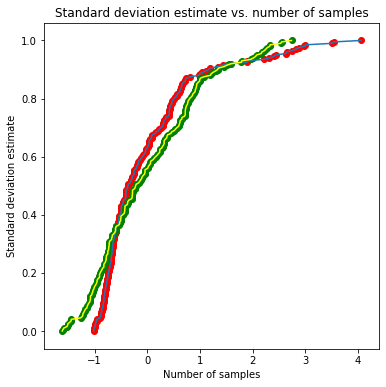

In [83]:
price_scale = scale(auto_price['price'].tolist()) # scale the price
log_price_scale = scale(auto_price['log_price'].tolist()) # scale the log price

plot_cums(price_scale, log_price_scale)  # plot the cumulative distribution function between those two lists

In [84]:
# Compute the K-S statistic and p-value for both price and log price
print('\033[1m\033[4mKS Test of price\033[0m')
ks_test(price_scale)
print('----------------------------------')
print('\033[1m\033[4mKS Test of log price\033[0m')
ks_test(log_price_scale)

KS Test of price
KS-statistic = 0.1542761480184771
P-value = 0.00012108611006800808
----------------------------------
KS Test of log price
KS-statistic = 0.09781904713791056
P-value = 0.03984598613097214


***
### Summary

- **From K-S statistics:** We found that **p-values are small for both price and log price.** We **can't reject the null hypothesis** since the chance is low for the difference to arise from random variation.
- **From the plot:** The two cumulative density function are quite similar. This indicates the two samples are drawn from the same distribution.
- These two samples have the same distribution
***

# 2. Test significance of price stratified by:

## a) Fuel Type

In [85]:
# Startify price by fuel type
data_by_fuel_type = pd.DataFrame({"var": auto_price['price'],
                     "group":auto_price['fuel-type']}) 

stratified_by_fuel_type = stratify(data_by_fuel_type, 0.05)
stratified_by_fuel_type

var   group
group                    
diesel 159   7788  diesel
       192  13845  diesel
       112  16900  diesel
       116  17950  diesel
       187   9495  diesel
       69   28176  diesel
       158   7898  diesel
       66   18344  diesel
       182   7775  diesel
       114  17075  diesel
gas    15   30760     gas
       161   8358     gas
       133  12170     gas
       145  11259     gas
       190   9980     gas
       77    6189     gas
       151   6338     gas
       39    8845     gas
       47   32250     gas
       125  22018     gas

In [86]:
# Count the fuel type and mean for each strata
stratified_by_fuel_type.reset_index(inplace=True, drop=True)
count_mean(stratified_by_fuel_type)

,count,mean
group,,
diesel,10,14524.6
gas,10,14816.7


In [87]:
diesel = stratified_by_fuel_type.loc[stratified_by_fuel_type['group'] == 'diesel'] # get the group 1 (diesel)
gas = stratified_by_fuel_type.loc[stratified_by_fuel_type['group'] == 'gas'] # get the group 2 (gas)

In [88]:
# Compute the t-statistics for these two groups
test_fuel = t_test(diesel.loc[:, 'var'], gas.loc[:, 'var'], 0.05)
test_fuel

DegFreedom      15.631662
Difference    -292.100000
Statistic       -0.078000
PValue           0.938818
Low95CI      -8246.096389
High95CI      7661.896389
dtype: float64

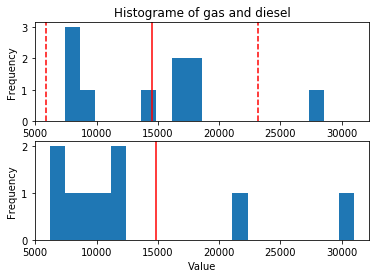

In [89]:
plot_t(diesel.loc[:, 'var'], gas.loc[:, 'var'], test_fuel, ['gas', 'diesel']) 

***
### Examine these results:
1. The t-statistic is small, the **p-value is large**, and the **confidence interval of the difference of the means overlap zero**. We have to **accept the null hypothesis** that the means are the same between gas and diesel. There is a high chance that the difference in means is from random variation alone.
2. The **mean of the second group (gas) falls inside the confidence interval**, confirming that **there is a high chance that the difference in means is from random variation alone**.
3. We can see from both histograms that the **distribution of fuel type are skewed to the left (asymmetric)**.
***

## b) Aspiration

In [90]:
# Startify price by aspiration
data_by_aspiration = pd.DataFrame({"var": auto_price['price'],
                     "group":auto_price['aspiration']}) 

stratified_by_aspiration = stratify(data_by_aspiration, 0.05)
stratified_by_aspiration

var  group
group                  
std   66   18344    std
      81    8499    std
      53    6695    std
      92    6849    std
      144   9233    std
      28    8921    std
      139   7053    std
      22    6377    std
      33    6529    std
      143   9960    std
turbo 149  11694  turbo
      114  17075  turbo
      8    23875  turbo
      116  17950  turbo
      67   25552  turbo
      82   12629  turbo
      136  18150  turbo
      119   7957  turbo
      112  16900  turbo
      203  22470  turbo

In [91]:
# Count the aspiration and mean for each strata
stratified_by_aspiration.reset_index(inplace=True, drop=True)
count_mean(stratified_by_aspiration)

,count,mean
group,,
std,10,8846.0
turbo,10,17425.2


In [92]:
std = stratified_by_aspiration.loc[stratified_by_aspiration['group'] == 'std'] # get the group 1 (standard)
turbo = stratified_by_aspiration.loc[stratified_by_aspiration['group'] == 'turbo'] # get the group 2 (turbo)

In [93]:
# Compute the t-statistics for these two groups
test_aspiration = t_test(std.loc[:, 'var'], turbo.loc[:, 'var'], 0.05)
test_aspiration

DegFreedom       15.330040
Difference    -8579.200000
Statistic        -4.096112
PValue            0.000915
Low95CI      -13035.109339
High95CI      -4123.290661
dtype: float64

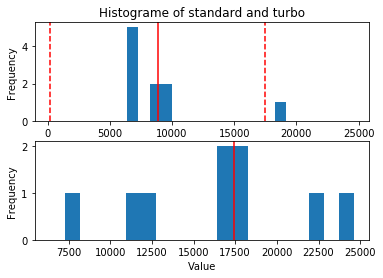

In [94]:
plot_t(std.loc[:, 'var'], turbo.loc[:, 'var'], test_aspiration, ['standard', 'turbo']) 

***
### Examine these results:
1. The t-statistic is small, the **p-value is large**, and the **confidence interval of the difference of the means overlap zero**. We have to **accept the null hypothesis** that the means are the same between standard and turbo. There is a high chance that the difference in means is from random variation alone.
2. The **mean of the second group (gas) falls inside the confidence interval**, confirming that **there is a high chance that the difference in means is from random variation alone**.
3. We can see from the histograms that the **distribution of the aspiration are sysmetric**.
4. **Note!** There is an outlier in the **standard** aspiration (from Lesson 1), so we might have a high chance that sometime we stratify those outliers into the sample which make the p-value confident interval redults different from 1 & 2 and we have to reject null hypothesis. We need to stratify many times to see these effects.
***

## c) Rear vs. Front Wheel Drive

In [95]:
auto_price = auto_price[auto_price['drive-wheels'] != '4wd'] # drop the '4wd' drive wheels's rows from the data frame

In [96]:
auto_price['drive-wheels'].unique() # check to make sure there are two type of drive wheels left in the data frame

array(['rwd', 'fwd'], dtype=object)

In [97]:
# Startify price by fuel type
data_by_drive_wheels = pd.DataFrame({"var": auto_price['price'],
                     "group":auto_price['drive-wheels']}) 

stratified_by_drive_wheels = stratify(data_by_drive_wheels, 0.05)
stratified_by_drive_wheels

var group
group                 
fwd   156   6938   fwd
      34    7129   fwd
      193  12290   fwd
      161   8358   fwd
      79    7689   fwd
      187   9495   fwd
      94    7299   fwd
      85    6989   fwd
      97    7999   fwd
rwd   115  16630   rwd
      202  21485   rwd
      171  11549   rwd
      10   16430   rwd
      201  19045   rwd
      66   18344   rwd
      196  15985   rwd
      12   20970   rwd
      70   31600   rwd

In [98]:
# Count the drive wheels and mean for each strata
stratified_by_drive_wheels.reset_index(inplace=True, drop=True)
count_mean(stratified_by_drive_wheels)

,count,mean
group,,
fwd,9,8242.888889
rwd,9,19115.333333


In [99]:
rwd = stratified_by_drive_wheels.loc[stratified_by_drive_wheels['group'] == 'rwd'] # get the group 1 (rear wheels)
fwd = stratified_by_drive_wheels.loc[stratified_by_drive_wheels['group'] == 'fwd'] # get the group 2 (front wheels)

In [100]:
# Compute the t-statistics for these two groups
test_drive_wheels = t_test(rwd.loc[:, 'var'], fwd.loc[:, 'var'], 0.05)
test_drive_wheels

DegFreedom        9.529634
Difference    10872.444444
Statistic         5.617719
PValue            0.000265
Low95CI        6531.113685
High95CI      15213.775204
dtype: float64

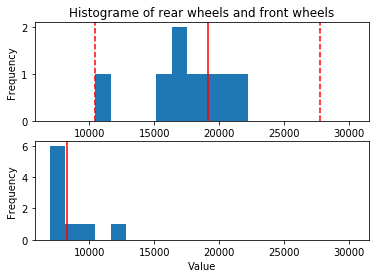

In [101]:
plot_t(rwd.loc[:, 'var'], fwd.loc[:, 'var'], test_drive_wheels, ['rear wheels', 'front wheels']) 

#### Examine these results:
1. The t-statistic is large, the **p-value is small, and the confidence interval of the difference of the means does not overlap zero**. We can **reject the null hypothesis that the means are the same between rear and front wheels**. There is a low chance that the difference in means is from random variation alone.
2. The **mean of the second sample falls outside the confidence interval**, confirming that there is a low chance that the difference in means is from random variation alone.
3. We can see from the histogram that rear wheels has symmetric dustribution while front wheels has asymmetric distribution (skewed to the left).

# 3. Use the Kolmogorov-Smirnov Test for Distributions

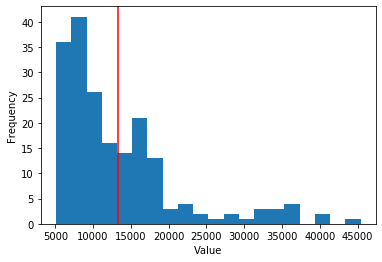

In [102]:
hist_plot(auto_price['price'], 20)

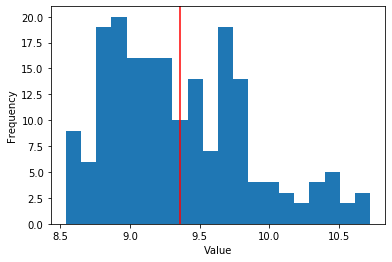

In [103]:
hist_plot(auto_price['log_price'], 20)

***
### Based on both histogram, I decide to test the auto price data compare to the log price since it's closer to a Normal Distribution.
***

In [104]:
# Check the counts for each body types, we will drop categories with insufficient data
auto_price[['counts', 'body-style']].groupby(['body-style']).agg('count')

,counts
body-style,
convertible,6
hardtop,8
hatchback,67
sedan,91
wagon,21


In [105]:
# Bsed on the above counts, I decide to drop convertible and hardtop since both have insufficient data
auto_price = auto_price[auto_price['body-style'] != 'convertible']
auto_price = auto_price[auto_price['body-style'] != 'hardtop']

In [106]:
# Create 3 groups of body style
df1 = auto_price[auto_price['body-style'] == 'hatchback']
df2 = auto_price[auto_price['body-style'] == 'sedan']
df3 = auto_price[auto_price['body-style'] == 'wagon']

In [107]:
# Compute the statistics for  these three groups
f_statistic, p_value = stats.f_oneway(df1['log_price'], df2['log_price'], df3['log_price']) 
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 8.976626457244592
P-value = 0.00019398707681679667


The **F statistic is fairly large and the p-value is small**. We can **reject the null hypothesis** that the 3 variables have the same mean, as the probability of the differences arising from random chance is quite low.

In [108]:
# Concatenate those three body styles with the group number into a data frame
df = pd.DataFrame({'vals': np.concatenate(( df1['log_price'],df2['log_price'], df3['log_price'])).flatten(),
                   'group_num': ['1'] * 67 + ['2'] * 91 + ['3'] * 21})
df

,vals,group_num
0,9.711116,1
1,8.546946,1
2,8.747511,1
3,8.625509,1
4,8.760453,1
...,...,...
174,9.664596,3
175,9.416541,3
176,9.504129,3
177,9.712024,3


In [109]:
# Compute Turkey's ANOVA
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.309  0.001  0.1332 0.4848   True
     1      3   0.2673 0.0566 -0.0058 0.5405  False
     2      3  -0.0417    0.9 -0.3061 0.2227  False
---------------------------------------------------


***
### Summary

- **From Tukey HSD statistics:** We found that **group 1 (hatchback) and group 2 (sedan)** have a significant difference at the 95% confidence level (the reject column on the right is True).
- The difference in means between the **group 1 (hatchback) and group 2 (sedan)** is significant since the confidence interval (lower and upper) are not include zero.
***

# 4. Graphically explore the differences between the price conditioned by the categories of body style

Text(0.5, 1.0, 'Box plot of variables')

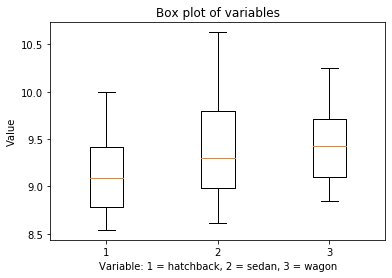

In [110]:
plt.boxplot([df1['log_price'], df2['log_price'], df3['log_price']])
plt.ylabel('Value')
plt.xlabel('Variable: 1 = hatchback, 2 = sedan, 3 = wagon')
plt.title('Box plot of variables')

# 5. Use standard ANOVA and Tukey HSD to test the differences of these groups

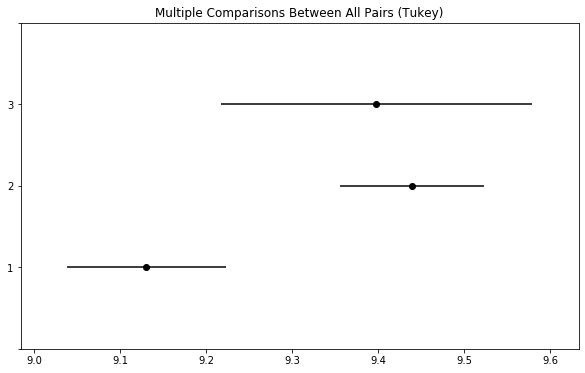

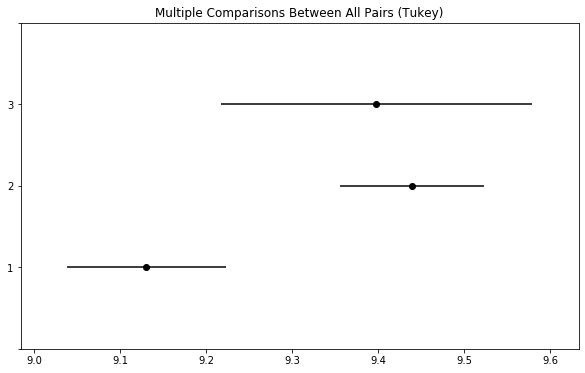

In [112]:
Tukey_HSD.plot_simultaneous()

***
### Summary

- **From the test result plots:** We found that the different in mean between **group 1 (hatchback) and group 2 (sedan)** is significant at the confidence level since the confidence intervals didn't not overlap at 95% confident level. We can **reject the null hypothesis** for group 1 (hatchback) and group 2 (sedan) and said both groups are not the same.
***